In [1]:
!pip install --upgrade quantecon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 179 kB 5.4 MB/s 


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import quantecon as qe
import random

from numba import njit, int64, float64, prange
from numba.experimental import jitclass
%matplotlib inline

In [6]:
class Arellano_Economy:
    " Stores data and creates primitives for the Arellano economy. "

    def __init__(self, 
            B_grid_size= 251,   # Grid size for bonds
            B_grid_min=-0.45,   # Smallest B value 
            B_grid_max=0.45,    # Largest B value
            y_grid_size=51,     # Grid size for income 
            β=0.953,            # Time discount parameter
            γ=2.0,              # Utility parameter
            r=0.017,            # Lending rate
            ρ=0.945,            # Persistence in the income process
            η=0.025,            # Standard deviation of the income process
            θ=0.282,            # Prob of re-entering financial markets 
            def_y_param=0.969): # Parameter governing income in default

        # Save parameters
        self.β, self.γ, self.r, = β, γ, r
        self.ρ, self.η, self.θ = ρ, η, θ

        self.y_grid_size = y_grid_size
        self.B_grid_size = B_grid_size
        self.B_grid = np.linspace(B_grid_min, B_grid_max, B_grid_size)
        mc = qe.markov.tauchen(ρ, η, 0, 3, y_grid_size)
        self.y_grid, self.P = np.exp(mc.state_values), mc.P

        # The index at which B_grid is (close to) zero
        self.B0_idx = np.searchsorted(self.B_grid, 1e-10)

        # Output recieved while in default, with same shape as y_grid
        self.def_y = np.minimum(def_y_param * np.mean(self.y_grid), self.y_grid)

    def params(self):
        return self.β, self.γ, self.r, self.ρ, self.η, self.θ 

    def arrays(self):
        return self.P, self.y_grid, self.B_grid, self.def_y, self.B0_idx

In [7]:
@njit
def u(c, γ):
    return c**(1-γ)/(1-γ)

In [8]:
@njit
def compute_q(v_c, v_d, q, params, arrays):
    """
    Compute the bond price function q(b, y) at each (b, y) pair.

    This function writes to the array q that is passed in as an argument.
    """

    # Unpack 
    β, γ, r, ρ, η, θ = params 
    P, y_grid, B_grid, def_y, B0_idx = arrays

    for B_idx in range(len(B_grid)):
        for y_idx in range(len(y_grid)):
            # Compute default probability and corresponding bond price
            default_states = 1.0 * (v_c[B_idx, :] < v_d)
            delta = np.dot(default_states, P[y_idx, :]) 
            q[B_idx, y_idx] = (1 - delta ) / (1 + r)

In [9]:
@njit
def T_d(y_idx, v_c, v_d, params, arrays):
    """
    The RHS of the Bellman equation when income is at index y_idx and
    the country has chosen to default.  Returns an update of v_d.
    """
    # Unpack 
    β, γ, r, ρ, η, θ = params 
    P, y_grid, B_grid, def_y, B0_idx = arrays

    current_utility = u(def_y[y_idx], γ)
    v = np.maximum(v_c[B0_idx, :], v_d)
    cont_value = np.sum((θ * v + (1 - θ) * v_d) * P[y_idx, :])

    return current_utility + β * cont_value


@njit
def T_c(B_idx, y_idx, v_c, v_d, q, params, arrays):
    """
    The RHS of the Bellman equation when the country is not in a
    defaulted state on their debt.  Returns a value that corresponds to
    v_c[B_idx, y_idx], as well as the optimal level of bond sales B'.
    """
    # Unpack 
    β, γ, r, ρ, η, θ = params 
    P, y_grid, B_grid, def_y, B0_idx = arrays
    B = B_grid[B_idx]
    y = y_grid[y_idx]

    # Compute the RHS of Bellman equation
    current_max = -1e10
    # Step through choices of next period B'
    for Bp_idx, Bp in enumerate(B_grid):
        c = y + B - q[Bp_idx, y_idx] * Bp
        if c > 0:
            v = np.maximum(v_c[Bp_idx, :], v_d)
            val = u(c, γ) + β * np.sum(v * P[y_idx, :])
            if val > current_max:
                current_max = val
                Bp_star_idx = Bp_idx
    return current_max, Bp_star_idx

In [10]:
@njit(parallel=True)
def update_values_and_prices(v_c, v_d,      # Current guess of value functions
                             B_star, q,     # Arrays to be written to
                             params, arrays):

    # Unpack 
    β, γ, r, ρ, η, θ = params 
    P, y_grid, B_grid, def_y, B0_idx = arrays
    y_grid_size = len(y_grid)
    B_grid_size = len(B_grid)

    # Compute bond prices and write them to q
    compute_q(v_c, v_d, q, params, arrays)

    # Allocate memory
    new_v_c = np.empty_like(v_c)
    new_v_d = np.empty_like(v_d)

    # Calculate and return new guesses for v_c and v_d
    for y_idx in prange(y_grid_size):
        new_v_d[y_idx] = T_d(y_idx, v_c, v_d, params, arrays)
        for B_idx in range(B_grid_size):
            new_v_c[B_idx, y_idx], Bp_idx = T_c(B_idx, y_idx, 
                                            v_c, v_d, q, params, arrays)
            B_star[B_idx, y_idx] = Bp_idx

    return new_v_c, new_v_d

In [11]:
def solve(model, tol=1e-8, max_iter=10_000):
    """
    Given an instance of Arellano_Economy, this function computes the optimal
    policy and value functions.
    """
    # Unpack
    params = model.params()
    arrays = model.arrays()
    y_grid_size, B_grid_size = model.y_grid_size, model.B_grid_size 

    # Initial conditions for v_c and v_d
    v_c = np.zeros((B_grid_size, y_grid_size))
    v_d = np.zeros(y_grid_size)

    # Allocate memory
    q = np.empty_like(v_c)
    B_star = np.empty_like(v_c, dtype=int)

    current_iter = 0
    dist = np.inf
    while (current_iter < max_iter) and (dist > tol):

        if current_iter % 100 == 0:
            print(f"Entering iteration {current_iter}.")

        new_v_c, new_v_d = update_values_and_prices(v_c, v_d, B_star, q, params, arrays)
        # Check tolerance and update
        dist = np.max(np.abs(new_v_c - v_c)) + np.max(np.abs(new_v_d - v_d))
        v_c = new_v_c
        v_d = new_v_d
        current_iter += 1

    print(f"Terminating at iteration {current_iter}.")
    return v_c, v_d, q, B_star 

In [12]:
def simulate(model, T, v_c, v_d, q, B_star, y_idx=None, B_idx=None):
    """
    Simulates the Arellano 2008 model of sovereign debt

    Here `model` is an instance of `Arellano_Economy` and `T` is the length of
    the simulation.  Endogenous objects `v_c`, `v_d`, `q` and `B_star` are
    assumed to come from a solution to `model`.

    """
    # Unpack elements of the model
    B0_idx = model.B0_idx
    y_grid = model.y_grid
    B_grid, y_grid, P = model.B_grid, model.y_grid, model.P

    # Set initial conditions to middle of grids
    if y_idx == None:
        y_idx = np.searchsorted(y_grid, y_grid.mean())
    if B_idx == None:
        B_idx = B0_idx
    in_default = False

    # Create Markov chain and simulate income process
    mc = qe.MarkovChain(P, y_grid)
    y_sim_indices = mc.simulate_indices(T+1, init=y_idx)

    # Allocate memory for outputs
    y_sim = np.empty(T)
    y_a_sim = np.empty(T)
    B_sim = np.empty(T)
    q_sim = np.empty(T)
    d_sim = np.empty(T, dtype=int)

    # Perform simulation
    t = 0
    while t < T:

        # Store the value of y_t and B_t
        y_sim[t] = y_grid[y_idx]
        B_sim[t] = B_grid[B_idx]

        # if in default:
        if v_c[B_idx, y_idx] < v_d[y_idx] or in_default:
            y_a_sim[t] = model.def_y[y_idx]
            d_sim[t] = 1
            Bp_idx = B0_idx
            # Re-enter financial markets next period with prob θ
            in_default = False if np.random.rand() < model.θ else True
        else:
            y_a_sim[t] = y_sim[t]
            d_sim[t] = 0
            Bp_idx = B_star[B_idx, y_idx]

        q_sim[t] = q[Bp_idx, y_idx]

        # Update time and indices
        t += 1
        y_idx = y_sim_indices[t]
        B_idx = Bp_idx

    return y_sim, y_a_sim, B_sim, q_sim, d_sim

In [13]:
ae = Arellano_Economy()

In [14]:
v_c, v_d, q, B_star = solve(ae)

Entering iteration 0.
Entering iteration 100.
Entering iteration 200.
Entering iteration 300.
Terminating at iteration 399.


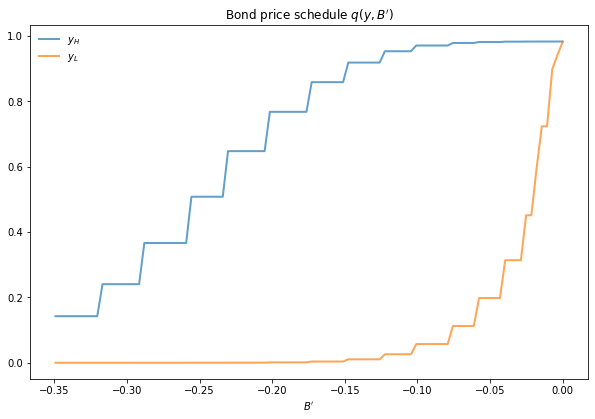

In [15]:
# Unpack some useful names
B_grid, y_grid, P = ae.B_grid, ae.y_grid, ae.P
B_grid_size, y_grid_size = len(B_grid), len(y_grid)
r = ae.r

# Create "Y High" and "Y Low" values as 5% devs from mean
high, low = np.mean(y_grid) * 1.05, np.mean(y_grid) * .95
iy_high, iy_low = (np.searchsorted(y_grid, x) for x in (high, low))

fig, ax = plt.subplots(figsize=(10, 6.5))
ax.set_title("Bond price schedule $q(y, B')$")

# Extract a suitable plot grid
x = []
q_low = []
q_high = []
for i, B in enumerate(B_grid):
    if -0.35 <= B <= 0:  # To match fig 3 of Arellano
        x.append(B)
        q_low.append(q[i, iy_low])
        q_high.append(q[i, iy_high])
ax.plot(x, q_high, label="$y_H$", lw=2, alpha=0.7)
ax.plot(x, q_low, label="$y_L$", lw=2, alpha=0.7)
ax.set_xlabel("$B'$")
ax.legend(loc='upper left', frameon=False)
plt.show()

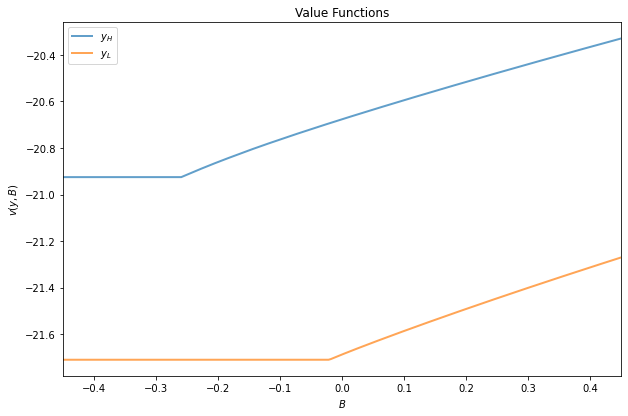

In [16]:
v = np.maximum(v_c, np.reshape(v_d, (1, y_grid_size)))

fig, ax = plt.subplots(figsize=(10, 6.5))
ax.set_title("Value Functions")
ax.plot(B_grid, v[:, iy_high], label="$y_H$", lw=2, alpha=0.7)
ax.plot(B_grid, v[:, iy_low], label="$y_L$", lw=2, alpha=0.7)
ax.legend(loc='upper left')
ax.set(xlabel="$B$", ylabel="$v(y, B)$")
ax.set_xlim(min(B_grid), max(B_grid))
plt.show()

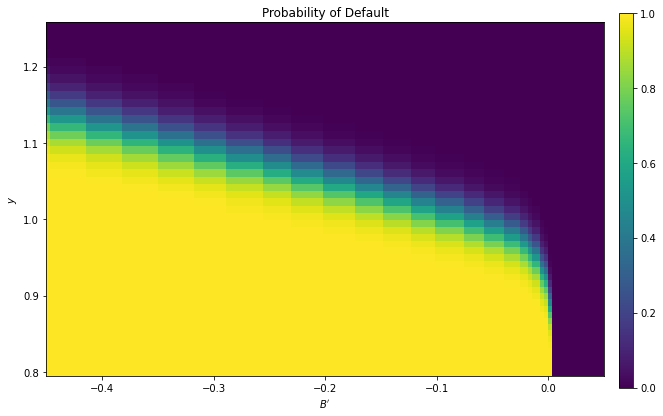

In [17]:
xx, yy = B_grid, y_grid
zz = np.empty_like(v_c)

for B_idx in range(B_grid_size):
    for y_idx in range(y_grid_size):
        default_states = 1.0 * (v_c[B_idx, :] < v_d)
        zz[B_idx, y_idx] = np.dot(default_states, P[y_idx, :]) 

# Create figure
fig, ax = plt.subplots(figsize=(10, 6.5))
hm = ax.pcolormesh(xx, yy, zz.T)
cax = fig.add_axes([.92, .1, .02, .8])
fig.colorbar(hm, cax=cax)
ax.axis([xx.min(), 0.05, yy.min(), yy.max()])
ax.set(xlabel="$B'$", ylabel="$y$", title="Probability of Default")
plt.show()

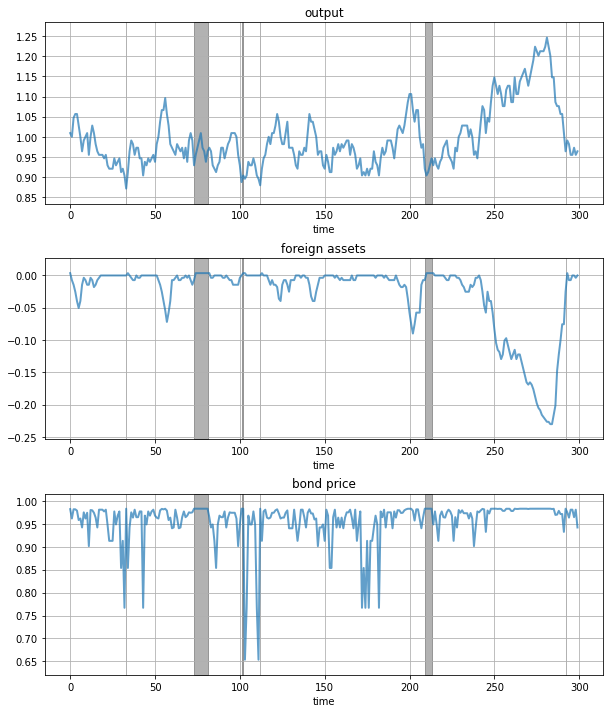

In [19]:
T = 300
np.random.seed(42)
y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(ae, T, v_c, v_d, q, B_star)

# Pick up default start and end dates
start_end_pairs = []
i = 0
while i < len(d_sim):
    if d_sim[i] == 0:
        i += 1
    else:
        # If we get to here we're in default
        start_default = i
        while i < len(d_sim) and d_sim[i] == 1:
            i += 1
        end_default = i - 1
        start_end_pairs.append((start_default, end_default))

plot_series = (y_sim, B_sim, q_sim)
titles = 'output', 'foreign assets', 'bond price'

fig, axes = plt.subplots(len(plot_series), 1, figsize=(10, 12))
fig.subplots_adjust(hspace=0.3)

for ax, series, title in zip(axes, plot_series, titles):
    # Determine suitable y limits
    s_max, s_min = max(series), min(series)
    s_range = s_max - s_min
    y_max = s_max + s_range * 0.1
    y_min = s_min - s_range * 0.1
    ax.set_ylim(y_min, y_max)
    for pair in start_end_pairs:
        ax.fill_between(pair, (y_min, y_min), (y_max, y_max),
                        color='k', alpha=0.3)
    ax.grid()
    ax.plot(range(T), series, lw=2, alpha=0.7)
    ax.set(title=title, xlabel="time")

plt.show()